<a href="https://colab.research.google.com/github/OleksandrZadvornyi/weather-forecasting/blob/main/prepare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q dask

In [3]:
!pip install -q gluonts ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [5]:
import glob

# When reading the CSV files, specify dtypes
dtypes = {
    'STATION': 'object',
    'DATE': 'object',  # Start as string, convert to datetime later
    'LATITUDE': 'float64',
    'LONGITUDE': 'float64',
    'ELEVATION': 'float64',
    'NAME': 'object',
    'PRCP': 'object',  # Keep as object initially to handle missing values
    'PRCP_ATTRIBUTES': 'object',
    'TMAX': 'object',
    'TMAX_ATTRIBUTES': 'object',
    'TMIN': 'object',
    'TMIN_ATTRIBUTES': 'object',
    'TAVG': 'object',
    'TAVG_ATTRIBUTES': 'object',
    'SNWD': 'object',
    'SNWD_ATTRIBUTES': 'object',
}

# 1. Load Ukrainian station data
ukrainian_files = glob.glob('/content/drive/MyDrive/weather_forecasting_project/daily-summaries-latest-upm/*.csv')
print(f"Found {len(ukrainian_files)} data files")

# Set files count limit
max_files = 100
ukrainian_files = ukrainian_files[:max_files]
print(f"Reading {len(ukrainian_files)} files")

Found 202 data files
Reading 100 files


In [6]:
import dask.dataframe as dd

# 2. Read and combine files
ddf = dd.read_csv(ukrainian_files, dtype=dtypes, assume_missing=True)
print(f"Data loaded with {len(ddf.columns)} columns")

Data loaded with 16 columns


In [7]:
import pandas as pd
import numpy as np

# 3. Apply preprocessing to sample for metadata
def preprocess(df):
    df = df.copy()

    df['DATE'] = pd.to_datetime(df['DATE'])

    # Ensure all expected columns exist, filling with NaN if necessary
    expected_columns = ['PRCP', 'TMAX', 'TMIN', 'TAVG']
    for col in expected_columns:
        if col not in df.columns:
            df[col] = np.nan  # Ensure column exists
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convert temperature from tenths of degrees Celsius to Celsius
    temperature_columns = ['TMAX', 'TMIN', 'TAVG']
    for col in temperature_columns:
        if col in df.columns:
            df[col] = df[col] / 10.0

    if 'TMAX' in df.columns and 'TMIN' in df.columns:
        df['TEMP_RANGE'] = df['TMAX'] - df['TMIN']

    df['MONTH'] = df['DATE'].dt.month
    df['DAY'] = df['DATE'].dt.day
    df['YEAR'] = df['DATE'].dt.year
    df['DAY_OF_YEAR'] = df['DATE'].dt.dayofyear
    df['SEASON'] = ((df['MONTH'] % 12) // 3 + 1).astype(int)

    cols_to_drop = [col for col in df.columns if '_ATTRIBUTES' in col]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Ensure column order matches the metadata
    expected_order = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
                      'PRCP', 'TMAX', 'TMIN', 'TAVG', 'TEMP_RANGE',
                      'MONTH', 'DAY', 'YEAR', 'DAY_OF_YEAR', 'SEASON']

    df = df.reindex(columns=expected_order)

    return df

def process_station_data(station_df):
    station_df = station_df.sort_values('DATE')

    if len(station_df) < 365:
        return None

    station_meta = station_df.iloc[0][['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].to_dict()

    station_df = station_df.set_index('DATE').loc[~station_df.index.duplicated(keep='first')]

    date_range = pd.date_range(start=station_df.index.min(), end=station_df.index.max(), freq='D')
    resampled_df = station_df.reindex(date_range)

    numeric_cols = ['PRCP', 'TMAX', 'TMIN', 'TAVG', 'TEMP_RANGE']
    numeric_cols = [col for col in numeric_cols if col in resampled_df.columns]

    def seasonal_interpolation(series):
        interpolated = series.interpolate(method='linear', limit=7)
        return interpolated.fillna(series.groupby(series.index.month).transform('median'))

    for col in numeric_cols:
        resampled_df[col] = resampled_df.groupby(resampled_df.index.month)[col].transform(seasonal_interpolation)

        if col in ['TMAX', 'TMIN', 'TAVG']:
            resampled_df[col] = resampled_df[col].fillna(resampled_df[col].rolling(window=15, center=True, min_periods=1).median())

        elif col == 'PRCP':
            log_interpolated = np.log1p(resampled_df[col] + 0.01).interpolate(method='cubic', limit=10)
            resampled_df[col] = np.maximum(np.expm1(log_interpolated), 0)

        resampled_df[col] = resampled_df[col].ffill(limit=60).bfill(limit=60)

        global_median = station_df[col].median()
        resampled_df[col] = resampled_df[col].fillna(global_median)

    for col in numeric_cols:
        if col in ['TMAX', 'TMIN', 'TAVG']:
            Q1, Q3 = resampled_df[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            resampled_df[col] = np.where((resampled_df[col] < lower_bound) | (resampled_df[col] > upper_bound), global_median, resampled_df[col])

        elif col == 'PRCP':
            resampled_df[col] = np.maximum(resampled_df[col], 0)

    for key, value in station_meta.items():
        resampled_df[key] = value

    resampled_df = resampled_df.reset_index().rename(columns={'index': 'DATE'})
    resampled_df['MONTH'], resampled_df['DAY'], resampled_df['YEAR'] = resampled_df['DATE'].dt.month, resampled_df['DATE'].dt.day, resampled_df['DATE'].dt.year
    resampled_df['DAY_OF_YEAR'] = resampled_df['DATE'].dt.dayofyear
    resampled_df['SEASON'] = ((resampled_df['MONTH'] % 12) // 3 + 1).astype(int)

    if 'TMAX' in resampled_df.columns and 'TMIN' in resampled_df.columns:
        resampled_df['TEMP_RANGE'] = resampled_df['TMAX'] - resampled_df['TMIN']

    # Final NaN check and global median replacement
    for col in numeric_cols:
        if resampled_df[col].isna().any():
            # print(f"Warning: Remaining NaNs in {col} column")
            global_median = station_df[col].median()
            resampled_df[col] = resampled_df[col].fillna(global_median)


    return resampled_df

# Create metadata by applying function to the first partition
meta_df = preprocess(ddf.partitions[0].head())

In [8]:
# 4. Apply preprocessing with metadata
print("Preprocessing data...")
ddf = ddf.map_partitions(preprocess, meta=meta_df)

Preprocessing data...


In [9]:
# 5. Convert Dask dataframe to Pandas for further processing
# This will load all data into memory (ensure you have enough RAM)
print("Converting to pandas dataframe...")
df = ddf.compute()

target_column = 'TMAX'

# Drop rows with NaN values
print("Dropping rows with NaN values...")
print(f"Total rows: {len(df)}")
df = df.dropna(subset=[target_column])
print(f"Rows remaining after dropping NaNs: {len(df)}")

Converting to pandas dataframe...
Dropping rows with NaN values...
Total rows: 2002466
Rows remaining after dropping NaNs: 864987


In [10]:
# 6. Create a time-indexed dataset
# Group by station and apply resampling
print("Resampling data by station...")
processed_stations = []
for station_id, station_df in df.groupby('STATION'):
    try:
        processed_station = process_station_data(station_df)
        if processed_station is not None:
            processed_stations.append(processed_station)
            print(f"Processed station {station_id} with {len(processed_station)} days of data")
    except Exception as e:
        print(f"Error processing station {station_id}: {e}")

# Combine all processed stations
print("Combining processed stations...")
if processed_stations:
    processed_df = pd.concat(processed_stations)
    print(f"Combined dataset has {len(processed_df)} rows")
else:
    raise ValueError("No stations were successfully processed")

Resampling data by station...
Processed station UPM00033362 with 22382 days of data
Processed station UPM00033368 with 9243 days of data
Processed station UPM00033376 with 20974 days of data
Processed station UPM00033377 with 32566 days of data
Processed station UPM00033382 with 3450 days of data
Processed station UPM00033391 with 18414 days of data
Processed station UPM00033392 with 3450 days of data
Processed station UPM00033759 with 18420 days of data
Processed station UPM00033761 with 27568 days of data
Processed station UPM00033777 with 24411 days of data
Processed station UPM00033788 with 18424 days of data
Processed station UPM00033791 with 27569 days of data
Processed station UPM00033805 with 24383 days of data
Processed station UPM00033830 with 2710 days of data
Processed station UPM00033833 with 20971 days of data
Processed station UPM00033834 with 24376 days of data
Processed station UPM00033836 with 1652 days of data
Processed station UPM00033837 with 47905 days of data
Pro

In [11]:
# 7. Split data into training/validation/test sets based on time
print("Splitting data into train/validation/test sets...")

# For each station, perform temporal split
train_data = {}
val_data = {}
test_data = {}

def split_time_series(processed_df, prediction_length=30):
    """
    Split dataframe by station into train/val/test sets based on time,
    where validation set extends prediction_length beyond training set,
    and test set extends prediction_length beyond validation set.
    """
    train_data = {}
    val_data = {}
    test_data = {}

    for station_id, station_df in processed_df.groupby('STATION'):
        # Ensure proper datetime column
        if not pd.api.types.is_datetime64_any_dtype(station_df['DATE']):
            station_df['DATE'] = pd.to_datetime(station_df['DATE'])

        # Sort by date
        station_df = station_df.sort_values('DATE')

        # Calculate split points
        n = len(station_df)

        # Ensure we have enough data for all splits
        if n < prediction_length * 2:
            print(f"Warning: Station {station_id} has insufficient data ({n} rows) for splits with prediction_length={prediction_length}")
            continue

        # Training set ends at (n - 2*prediction_length)
        train_end = n - 2 * prediction_length
        # Validation set extends prediction_length beyond training
        val_end = n - prediction_length

        # Split the data
        train = station_df.iloc[:train_end].copy()
        val = station_df.iloc[:val_end].copy()  # Includes training data plus prediction_length more
        test = station_df.copy()  # All data, includes val plus prediction_length more

        # Store in dictionaries
        train_data[station_id] = train
        val_data[station_id] = val
        test_data[station_id] = test

    return train_data, val_data, test_data

prediction_length = 30
train_data, val_data, test_data = split_time_series(processed_df, prediction_length=prediction_length)

Splitting data into train/validation/test sets...


In [12]:
# 8. Prepare data for GluonTS format
# First, let's convert the data into the appropriate format for each split
print("Converting data to GluonTS format...")

def prepare_gluonts_data(data_dict, target_column='TMAX'):
    """
    Convert dictionary of dataframes to GluonTS dataset format.

    Args:
        data_dict: Dictionary of dataframes, keyed by station_id
        target_column: Column to use as target variable

    Returns:
        List of dictionaries in GluonTS format
    """
    gluonts_data = []

    # Create a mapping of station IDs to unique categorical indices
    station_ids = list(data_dict.keys())
    station_id_to_cat = {station_id: idx for idx, station_id in enumerate(station_ids)}

    for station_id, df in data_dict.items():
        # Ensure the dataframe has a proper date index or DATE column
        if 'DATE' in df.columns:
            # If DATE is a column, ensure it's a datetime
            if not pd.api.types.is_datetime64_any_dtype(df['DATE']):
                df['DATE'] = pd.to_datetime(df['DATE'])

            # Sort by DATE
            df = df.sort_values('DATE')

            # Get start timestamp as a proper pandas Timestamp
            start = df['DATE'].iloc[0]
        else:
            # If using an index, ensure it's a datetime index
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)

            # Sort by date index
            df = df.sort_index()

            # Get start timestamp
            start = df.index[0]

        # Convert start to string format that GluonTS can handle
        # Format: YYYY-MM-DD HH:MM:SS
        start_str = start.strftime('%Y-%m-%d %H:%M:%S')

        # Extract target variable
        target = df[target_column].values.astype(np.float32)

        # Create static categorical feature
        static_cat = [station_id_to_cat[station_id]]

        # Create optional static real features
        static_real = [
            df['LATITUDE'].iloc[0],
            df['LONGITUDE'].iloc[0],
            df['ELEVATION'].iloc[0]
        ]

        # Create dictionary in GluonTS format
        ts_data = {
            "start": start_str,  # Store as string for consistent handling
            "target": target,
            "feat_static_cat": static_cat,
            "feat_static_real": static_real,
            "item_id": station_id
        }

        gluonts_data.append(ts_data)

    return gluonts_data

# Choose target variable
#target_column = 'TMIN'  # Can be changed to TMIN, PRCP, etc.

# Convert data to GluonTS format
train_gluonts = prepare_gluonts_data(train_data, target_column)
val_gluonts = prepare_gluonts_data(val_data, target_column)
test_gluonts = prepare_gluonts_data(test_data, target_column)

print(f"Created {len(train_gluonts)} training series, {len(val_gluonts)} validation series, {len(test_gluonts)} test series")


Converting data to GluonTS format...
Created 90 training series, 90 validation series, 90 test series


In [13]:
from datasets import Dataset, Features, Value, Sequence
from gluonts.itertools import Map

# 9. Create HuggingFace Datasets
print("Creating HuggingFace Datasets...")

# Process start field for HuggingFace Dataset
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        # Convert start from string to datetime
        if isinstance(data["start"], str):
            data["start"] = pd.Timestamp(data["start"])

        # Ensure start is a timestamp
        if isinstance(data["start"], pd.Timestamp):
            data["start"] = data["start"].to_pydatetime()

        # Assign a unique ID to each time series
        if "feat_static_cat" not in data:
            data["feat_static_cat"] = [self.ts_id]

        self.ts_id += 1
        return data

# Apply processing to each split
process_start = ProcessStartField()
train_processed = list(Map(process_start, train_gluonts))
process_start = ProcessStartField()  # Reset ID counter
val_processed = list(Map(process_start, val_gluonts))
process_start = ProcessStartField()  # Reset ID counter
test_processed = list(Map(process_start, test_gluonts))

# Define dataset features
features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("int64")),
        "feat_static_real": Sequence(Value("float32")),
        "item_id": Value("string"),
    }
)

# Create HuggingFace Datasets
train_dataset = Dataset.from_list(train_processed, features=features)
val_dataset = Dataset.from_list(val_processed, features=features)
test_dataset = Dataset.from_list(test_processed, features=features)


Creating HuggingFace Datasets...


In [14]:
import shutil
import os

from datasets import DatasetDict

# 10. Save the prepared datasets
print("Saving prepared datasets...")
data_dir = "/content/drive/MyDrive/weather_forecasting_project/prepared_datasets"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.makedirs(data_dir, exist_ok=True)

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Save the DatasetDict
dataset.save_to_disk(f"{data_dir}/dataset")

# Save target column information
with open(f"{data_dir}/metadata.txt", "w") as f:
    f.write(f"target_column={target_column}\n")
    f.write("freq=D\n")  # Daily frequency
    f.write(f"prediction_length={prediction_length}\n")

print("Data preparation complete!")
print("Datasets saved to:", data_dir)
print("Final dataset sizes:")
print(f"Train: {len(train_dataset)} series")
print(f"Validation: {len(val_dataset)} series")
print(f"Test: {len(test_dataset)} series")

Saving prepared datasets...


Saving the dataset (0/1 shards):   0%|          | 0/90 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/90 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/90 [00:00<?, ? examples/s]

Data preparation complete!
Datasets saved to: /content/drive/MyDrive/weather_forecasting_project/prepared_datasets
Final dataset sizes:
Train: 90 series
Validation: 90 series
Test: 90 series


In [15]:
train_dataset[0]["item_id"]

'UPM00033362'

In [16]:
print(pd.Timestamp(train_dataset[0]["start"]))
print(pd.Timestamp(val_dataset[0]["start"]))
print(pd.Timestamp(test_dataset[0]["start"]))

1955-03-05 00:00:00
1955-03-05 00:00:00
1955-03-05 00:00:00


Train start: 1955-03-05 00:00:00, length: 22322
Val start: 1955-03-05 00:00:00, length: 22352
Test start: 1955-03-05 00:00:00, length: 22382


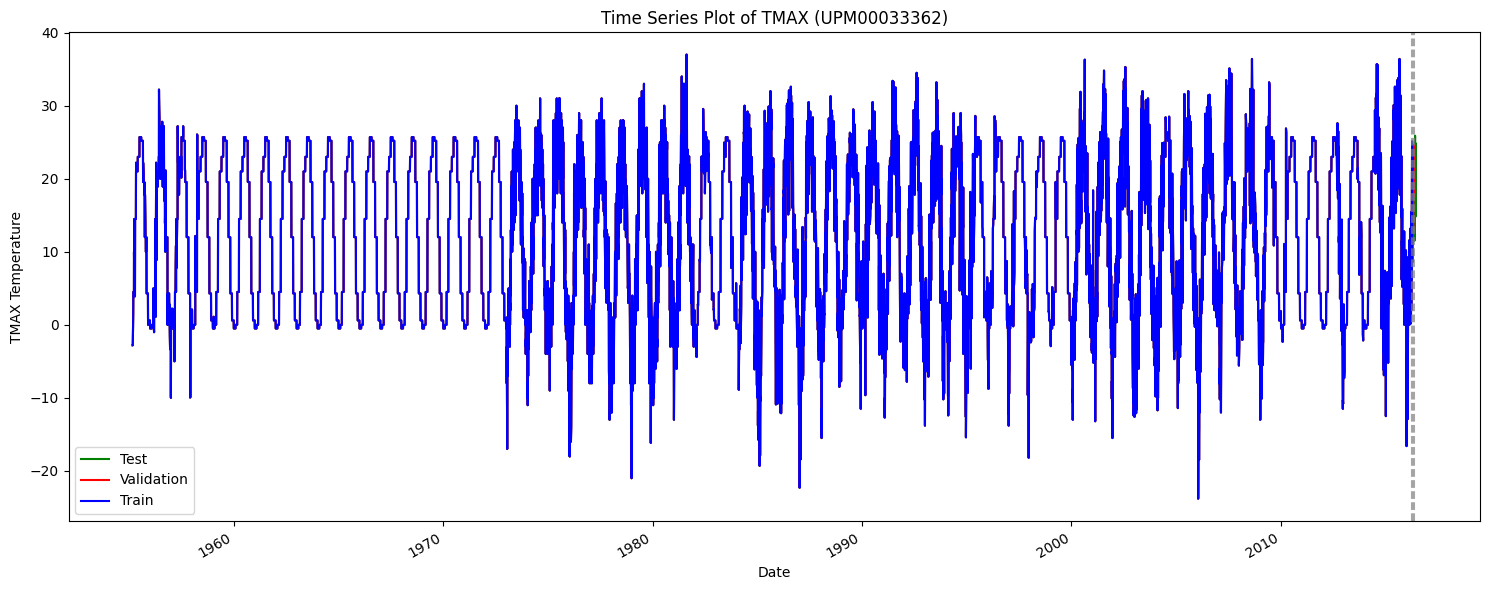

Train start: 1959-01-02 00:00:00, length: 9183
Val start: 1959-01-02 00:00:00, length: 9213
Test start: 1959-01-02 00:00:00, length: 9243


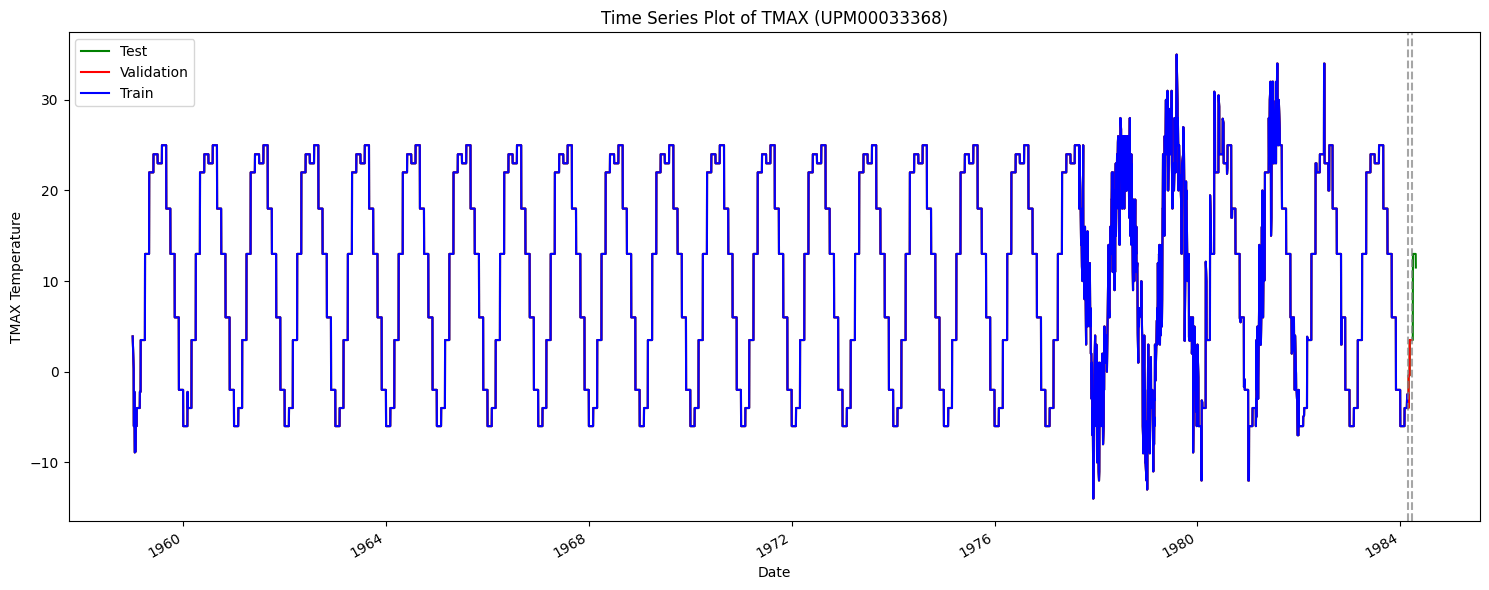

Train start: 1959-01-11 00:00:00, length: 20914
Val start: 1959-01-11 00:00:00, length: 20944
Test start: 1959-01-11 00:00:00, length: 20974


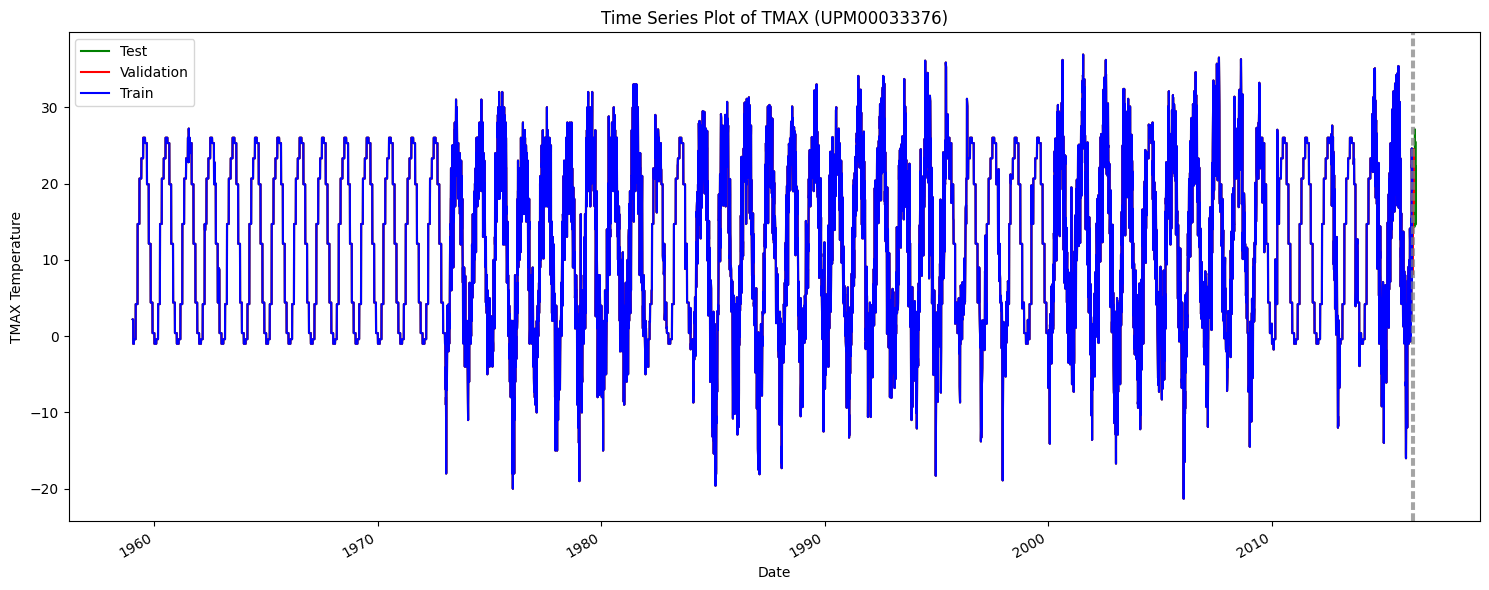

Train start: 1936-01-01 00:00:00, length: 32506
Val start: 1936-01-01 00:00:00, length: 32536
Test start: 1936-01-01 00:00:00, length: 32566


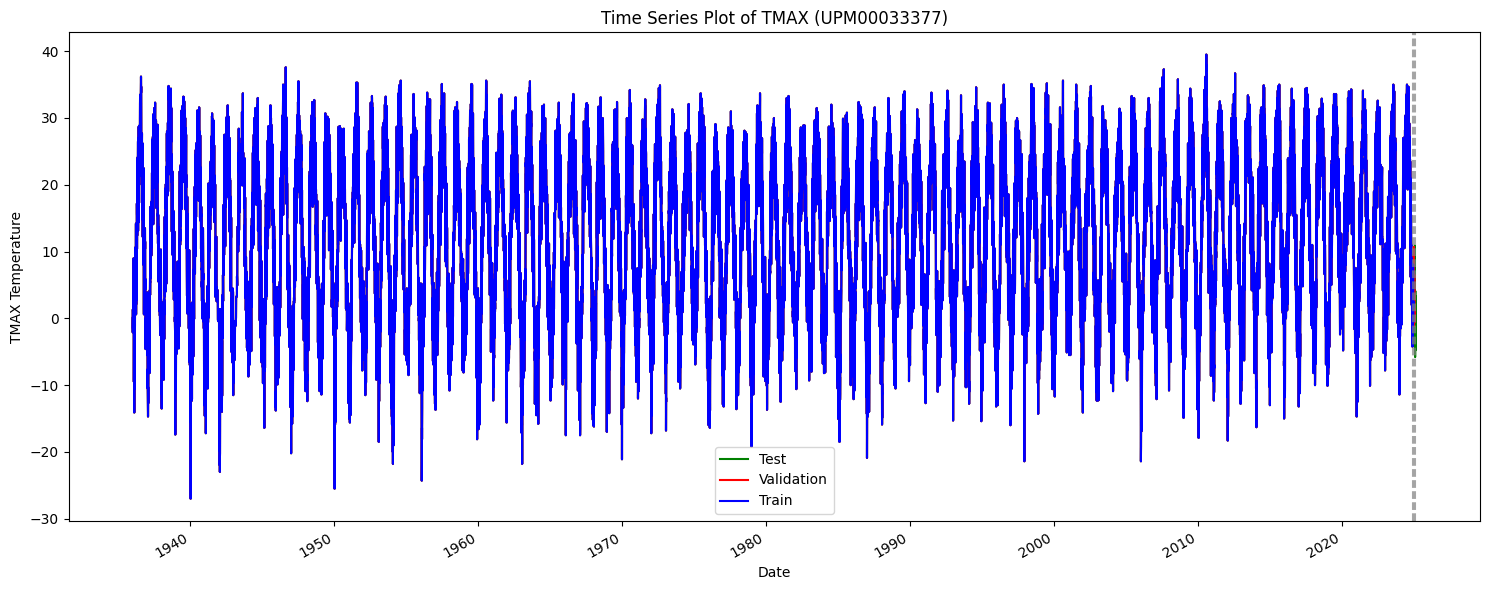

Train start: 2000-01-01 00:00:00, length: 3390
Val start: 2000-01-01 00:00:00, length: 3420
Test start: 2000-01-01 00:00:00, length: 3450


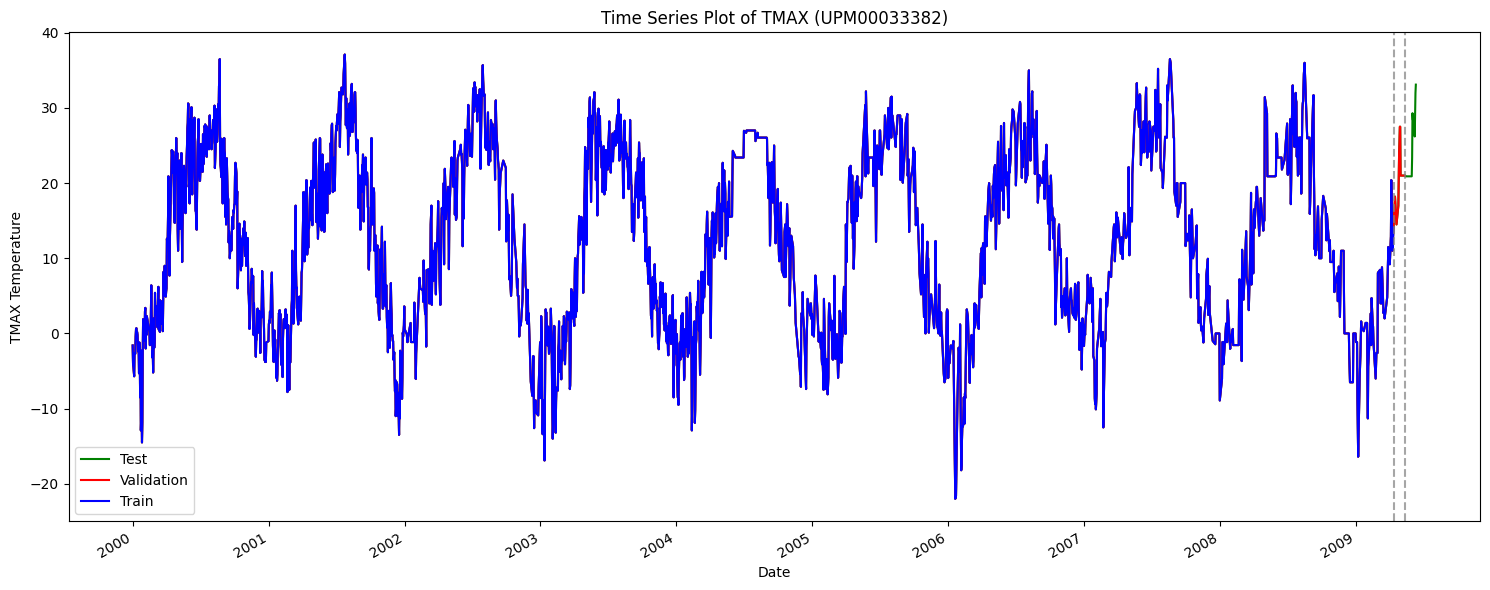

Train start: 1959-01-12 00:00:00, length: 18354
Val start: 1959-01-12 00:00:00, length: 18384
Test start: 1959-01-12 00:00:00, length: 18414


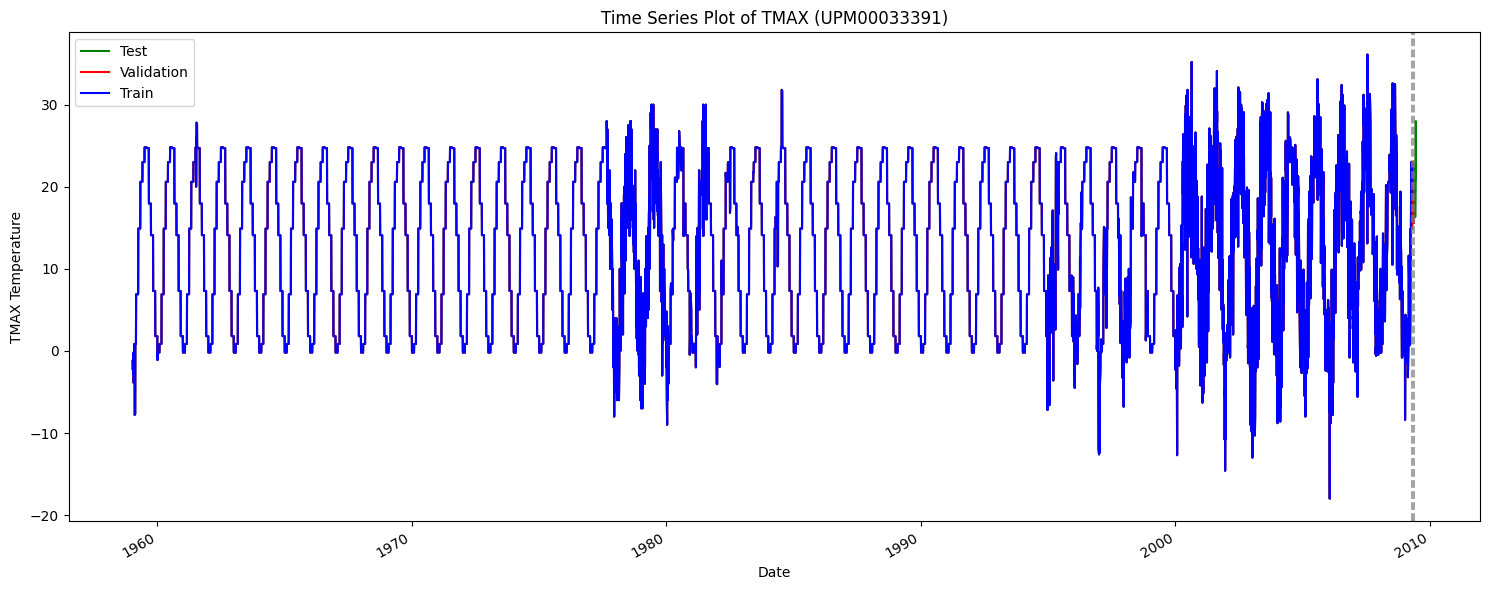

Train start: 2000-01-01 00:00:00, length: 3390
Val start: 2000-01-01 00:00:00, length: 3420
Test start: 2000-01-01 00:00:00, length: 3450


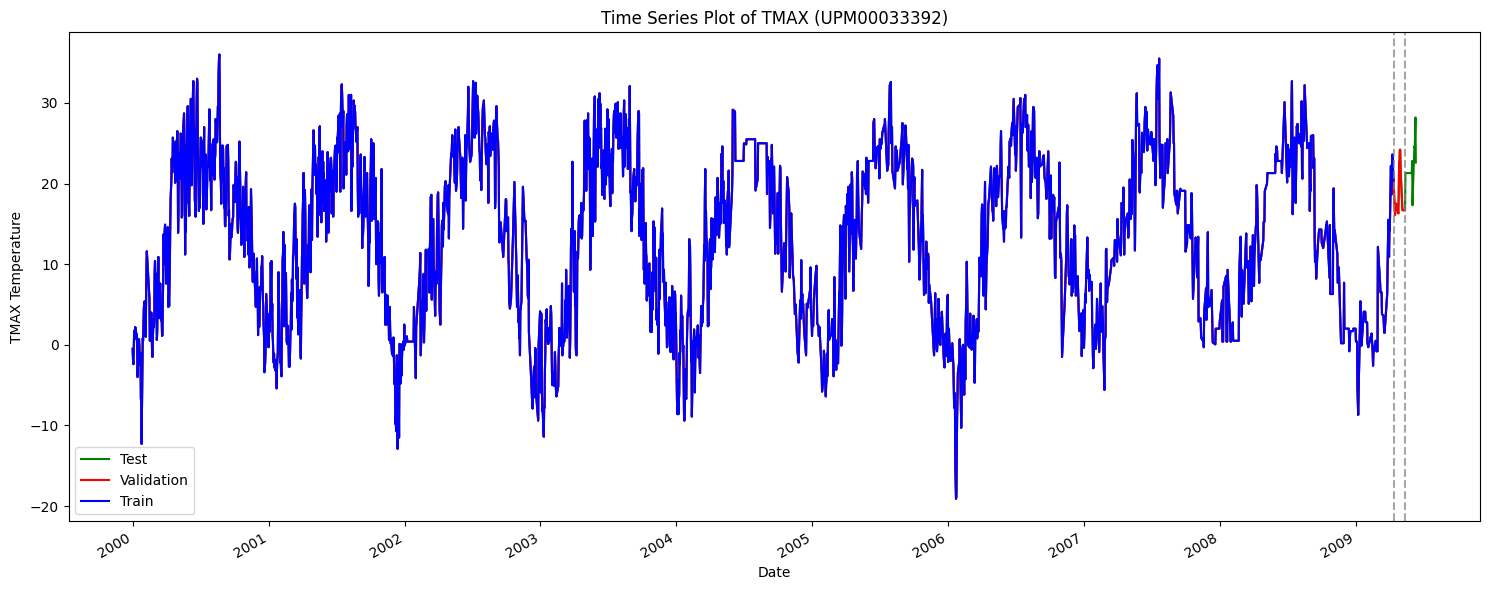

Train start: 1959-01-06 00:00:00, length: 18360
Val start: 1959-01-06 00:00:00, length: 18390
Test start: 1959-01-06 00:00:00, length: 18420


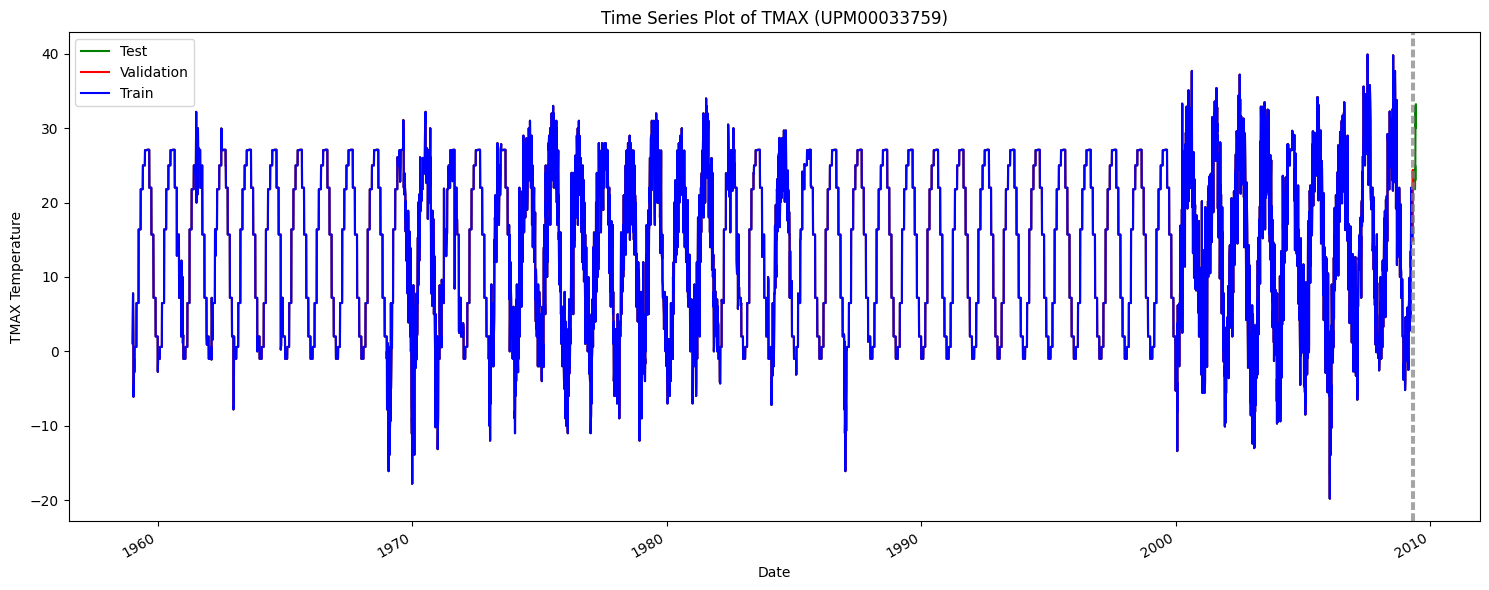

Train start: 1949-09-07 00:00:00, length: 27508
Val start: 1949-09-07 00:00:00, length: 27538
Test start: 1949-09-07 00:00:00, length: 27568


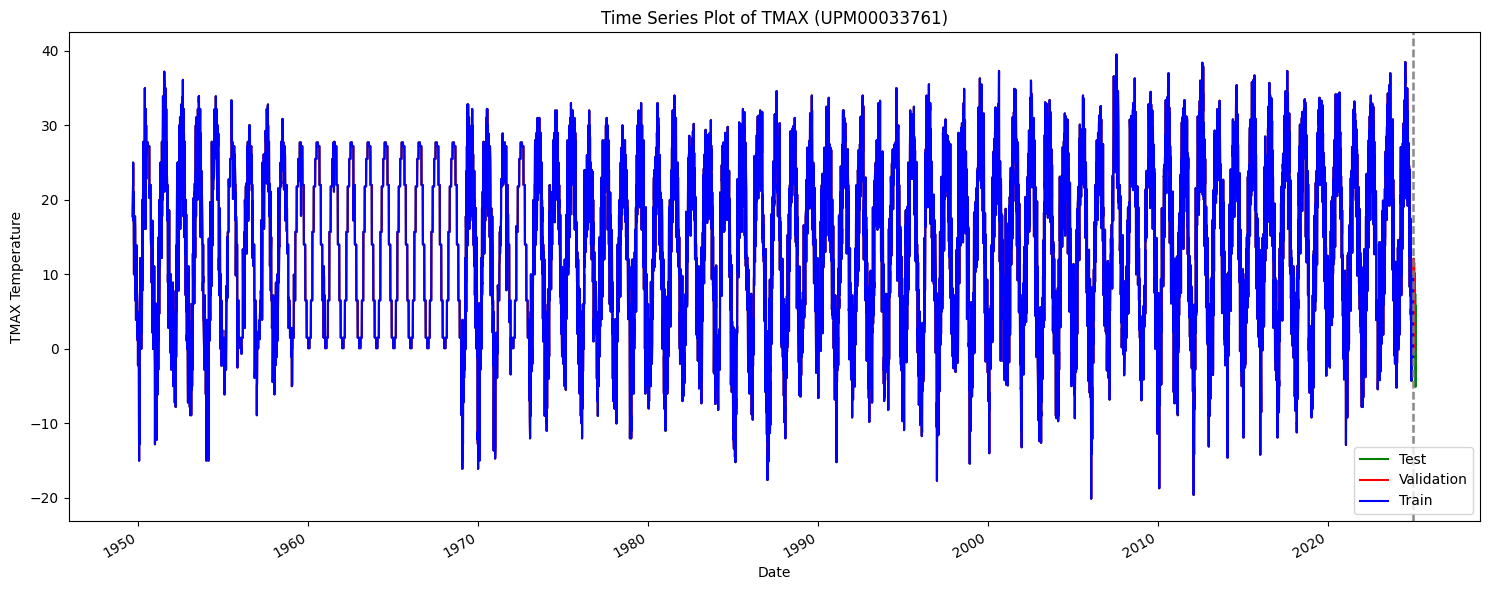

Train start: 1949-08-14 00:00:00, length: 24351
Val start: 1949-08-14 00:00:00, length: 24381
Test start: 1949-08-14 00:00:00, length: 24411


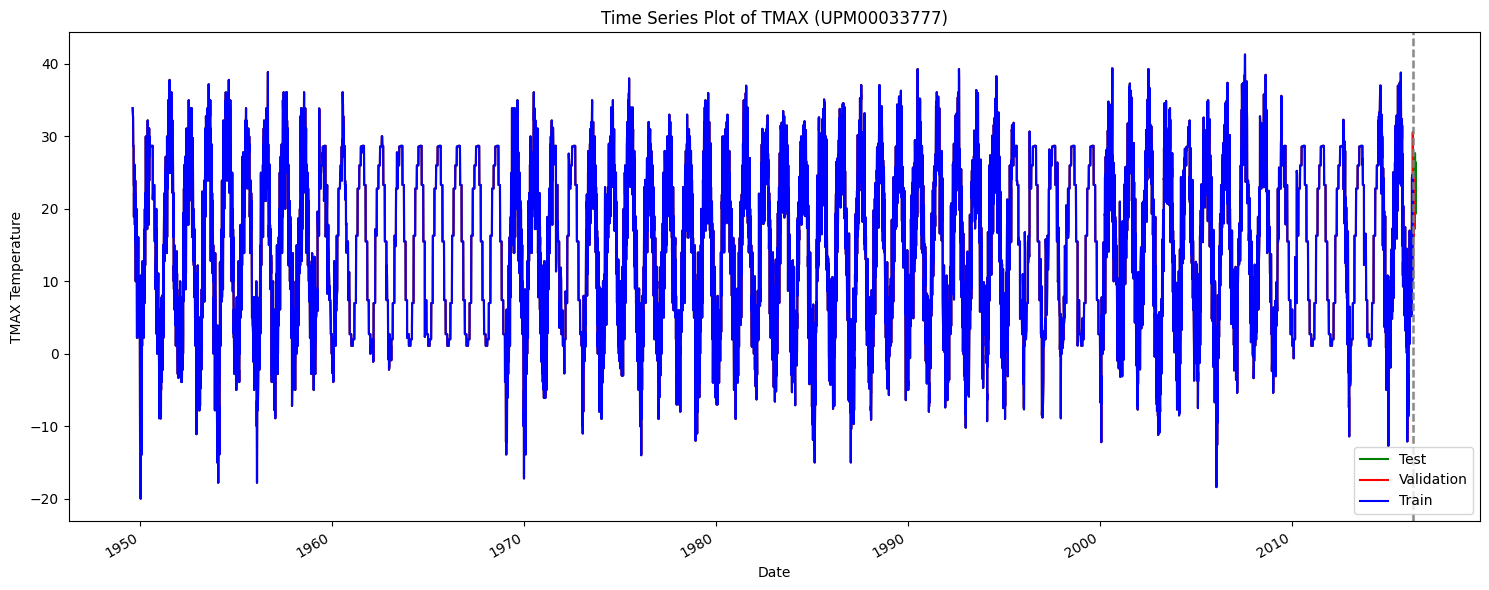

In [17]:
import matplotlib.pyplot as plt

def plot_sequential_time_series(train_example, validation_example, test_example,
                             title=None, target_column="TMAX"):
    """
    Plot time series data sequentially from train, validation, and test sets with datetime on x-axis.
    """
    # Create a figure and axis
    plt.figure(figsize=(15, 6))

    # Extract target values
    train_target = train_example["target"]
    validation_target = validation_example["target"]
    test_target = test_example["target"]

    # Get start dates - parse with pandas to ensure proper handling
    train_start = pd.Timestamp(train_example["start"])
    val_start = pd.Timestamp(validation_example["start"])
    test_start = pd.Timestamp(test_example["start"])

    # Debugging info
    print(f"Train start: {train_start}, length: {len(train_target)}")
    print(f"Val start: {val_start}, length: {len(validation_target)}")
    print(f"Test start: {test_start}, length: {len(test_target)}")

    # Create date ranges for each dataset
    train_dates = pd.date_range(start=train_start, periods=len(train_target), freq='D')
    val_dates = pd.date_range(start=val_start, periods=len(validation_target), freq='D')
    test_dates = pd.date_range(start=test_start, periods=len(test_target), freq='D')

    # Plot each array with actual dates
    plt.plot(test_dates, test_target, color="green", label="Test")
    plt.plot(val_dates, validation_target, color="red", label="Validation")
    plt.plot(train_dates, train_target, color="blue", label="Train")

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel(f"{target_column} Temperature")
    plt.title(title or f"Time Series Plot of {target_column} ({train_example['item_id']})")
    plt.legend()

    # Add vertical lines to separate datasets
    if len(train_dates) > 0:
        plt.axvline(x=train_dates[-1], color='gray', linestyle='--', alpha=0.7)
    if len(val_dates) > 0:
        plt.axvline(x=val_dates[-1], color='gray', linestyle='--', alpha=0.7)

    # Format x-axis dates
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.tight_layout()
    plt.show()

for x in range(10):
    plot_sequential_time_series(
        train_dataset[x],
        val_dataset[x],
        test_dataset[x],
        target_column=target_column
    )